### Image preprocessing

In [1]:
import numpy as np
from scipy.signal import spectrogram
import pylab as plt

def to_Spectrogram(data):
    _ , _ , Sx = spectrogram(data, fs=300, nperseg=300, noverlap=150, scaling='spectrum', detrend=False, window='hanning')
    Sx = np.log10(Sx)
    tmp = np.transpose(Sx)
    return tmp

trainD = np.load("/home/hsiehch/30s/train_data.npy")
validationD = np.load("/home/hsiehch/30s/validation_data.npy")
testD = np.load("/home/hsiehch/30s/test_data.npy")

trainL = np.load("/home/hsiehch/30s/train_label.npy")
validationL = np.load("/home/hsiehch/30s/validation_label.npy")
testL = np.load("/home/hsiehch/30s/test_label.npy")

trainD = np.append(trainD, validationD, axis=0)
trainD = np.append(trainD, testD, axis=0)

trainL = np.append(trainL, validationL, axis=0)
trainL = np.append(trainL, testL, axis=0)

data = []
labels = []

for i in range(len(trainD)):
#     record = to_Spectrogram(trainD[i])
#     data.append(record)
    data.append(trainD[i])
    labels.append(trainL[i])

data = np.array(data)
labels = np.array(labels)

def foo(data, labels):
    
    type0 = []
    type1 = []
    type2 = []
    type3 = []
    
    L0 = []
    L1 = []
    L2 = []
    L3 = []
    
    for i in range(len(labels)):
        if labels[i] == 0:
            type0.append(data[i])
            L0.append(labels[i])
        if labels[i] == 1:
            type1.append(data[i])
            L1.append(labels[i])
        if labels[i] == 2:
            type2.append(data[i])
            L2.append(labels[i])
        if labels[i] == 3:
            type3.append(data[i])
            L3.append(labels[i])
        
    type0 = np.array(type0)
    type1 = np.array(type1)
    type2 = np.array(type2)
    type3 = np.array(type3)
    
    L0 = np.array(L0)
    L1 = np.array(L1)
    L2 = np.array(L2)
    L3 = np.array(L3)
    
    type0 = np.append(type0, type1, axis=0)
    type0 = np.append(type0, type2, axis=0)
    type0 = np.append(type0, type3, axis=0)
    
    L0 = np.append(L0, L1, axis=0)
    L0 = np.append(L0, L2, axis=0)
    L0 = np.append(L0, L3, axis=0)
    
    return type0, L0

data, labels = foo(data, labels)

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, AveragePooling1D, Dropout
from keras.layers import Activation, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
import tensorflow as tf
from keras.callbacks import TensorBoard, EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
np.set_printoptions(suppress=True)

trainData = data.reshape((data.shape[0], data.shape[1], 1))
trainLabel = np_utils.to_categorical(labels, 4)
print('Train Data:', trainData.shape)
print('Train Label: ', trainLabel.shape)

#--------------------------------------------

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True)

#--------------------------------------------

from sklearn.metrics import f1_score

def create_model():
    model = Sequential()
    model.add(Conv1D(filters = 32, kernel_size = 7, input_shape = (trainData.shape[1], 1)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size = 2))

    model.add(Conv1D(filters = 32, kernel_size = 7))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))

    model.add(Conv1D(filters = 64, kernel_size = 7))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))

    model.add(Conv1D(filters = 64, kernel_size = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))

    model.add(Conv1D(filters = 128, kernel_size = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))

    model.add(Conv1D(filters = 128, kernel_size = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Dropout(0.5))

    model.add(Conv1D(filters = 256, kernel_size = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))

    model.add(Conv1D(filters = 256, kernel_size = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Dropout(0.5))

    model.add(Conv1D(filters = 512, kernel_size = 3))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Dropout(0.5))

    model.add(Conv1D(filters = 512, kernel_size = 3))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(4, activation = "softmax"))
    
    model.compile(optimizer = 'adam', loss = "categorical_crossentropy", metrics=['accuracy'])

    return model

fold = 1

for train_index, test_index in kf.split(trainData):
    
    print('{}-Fold'.format(fold))
    model = create_model()
    early_stop = EarlyStopping(patience=20)
    history = model.fit(x = trainData[train_index],
                        y = trainLabel[train_index],
                        epochs=100,
                        validation_data=(trainData[test_index], trainLabel[test_index]),
                        callbacks=[early_stop],
                        batch_size=70, 
                        verbose=0)
    
    evaluation = model.evaluate(x = trainData[train_index], y = trainLabel[train_index])
    print('Training:')
    print('Loss: {:.3f}, Accuracy: {:.3f}'.format(evaluation[0], evaluation[1]))
#     test_prediction = model.predict_classes(trainData[train_index], batch_size=1)
#     cnf_matrix = confusion_matrix(trainLabel[train_index].argmax(axis=1), test_prediction)
#     plot_confusion_matrix(cnf_matrix, classes=['AF','Noise','Normal','Other'],
#                       title='Confusion matrix')
    
    evaluation = model.evaluate(x = trainData[test_index], y = trainLabel[test_index])
    print('Testing:')
    print('Loss: {:.3f}, Accuracy: {:.3f}'.format(evaluation[0], evaluation[1]))
#     test_prediction = model.predict_classes(trainData[test_index], batch_size=1)
#     cnf_matrix = confusion_matrix(trainLabel[test_index].argmax(axis=1), test_prediction)
#     plot_confusion_matrix(cnf_matrix, classes=['AF','Noise','Normal','Other'],
#                       title='Confusion matrix')
    
    validation_prediction = model.predict_classes(trainData[test_index], batch_size=100)
    validation_prediction = np_utils.to_categorical(validation_prediction, 4)
    result = f1_score(trainLabel[test_index], validation_prediction, average=None)
    print('F1-score:')
    print(result)
    
    fold = fold + 1
    del model
    

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train Data: (10151, 9000, 1)
Train Label:  (10151, 4)
1-Fold
8120/8120 [==============================] - 3s 335us/step
Training:
Loss: 0.228, Accuracy: 0.917
2031/2031 [==============================] - 1s 342us/step
Testing:
Loss: 0.548, Accuracy: 0.841
F1-score:
[0.7615894  0.688      0.90178926 0.74464286]
2-Fold
8121/8121 [==============================] - 3s 339us/step
Training:
Loss: 0.303, Accuracy: 0.891
2030/2030 [==============================] - 1s 347us/step
Testing:
Loss: 0.437, Accuracy: 0.840
F1-score:
[0.82228117 0.68253968 0.89932352 0.72413793]
3-Fold
8121/8121 [==============================] - 3s 334us/step
Training:
Loss: 0.328, Accuracy: 0.877
2030/2030 [==============================] - 1s 336us/step
Testing:
Loss: 0.527, Accuracy: 0.831
F1-score:
[0.75496689 0.45977011 0.89379845 0.73143905]
4-Fold
8121/8121 [==============================] - 3s 335us/step
Training:
Loss: 0.290, Accuracy: 0.894
2030/2030 [==============================] - 1s 334us/step
Testing:

### 2D LSTM

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D
from keras.layers import BatchNormalization, Activation, LSTM
from keras.utils import np_utils
import tensorflow as tf
np.set_printoptions(suppress=True)

data = np.load("/home/hsiehch/30s/2D_spect_img/data.npy")
labels = np.load('/home/hsiehch/30s/2D_spect_img/labels.npy')

data = data / 255
labels = np_utils.to_categorical(labels, 4)

print(data.shape)
print(labels.shape)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(10151, 59, 151)
(10151, 4)


In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels)

In [3]:
from keras.models import Sequential
from keras.optimizers import Adam

model = Sequential()
model.add(LSTM(1024, input_shape = (data.shape[1], data.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation="softmax"))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1024)              4816896   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 5,474,052
Trainable params: 5,474,052
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
adam = Adam(lr=0.0005)
model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics=['accuracy'])
batch_s = 100
train_history = model.fit(x = X_train, 
                          y = y_train,
                          epochs=100,
                          validation_data=(X_test, y_test),
                          batch_size=batch_s, 
                          verbose=1)

print('Finish training!')

import pylab as plt
def history_display(hist, train, validation):
    plt.plot(hist.history[train])
    plt.plot(hist.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show
    
def show_plot(flag, hist):
    if flag == 'acc':
        history_display(hist, 'acc', 'val_acc')
    elif flag == 'loss':
        history_display(hist, 'loss', 'val_loss')
    else:
        print('Invalid!')

Train on 7613 samples, validate on 2538 samples
Epoch 1/100
7613/7613 [==============================] - 17s 2ms/step - loss: 1.0103 - acc: 0.5780 - val_loss: 1.0019 - val_acc: 0.5827
Epoch 2/100
7613/7613 [==============================] - 13s 2ms/step - loss: 0.9965 - acc: 0.5885 - val_loss: 0.9916 - val_acc: 0.5827
Epoch 3/100
7613/7613 [==============================] - 13s 2ms/step - loss: 0.9912 - acc: 0.5885 - val_loss: 0.9983 - val_acc: 0.5827
Epoch 4/100
7613/7613 [==============================] - 12s 2ms/step - loss: 0.9924 - acc: 0.5885 - val_loss: 0.9900 - val_acc: 0.5827
Epoch 5/100
7613/7613 [==============================] - 12s 2ms/step - loss: 0.9868 - acc: 0.5885 - val_loss: 0.9895 - val_acc: 0.5827
Epoch 6/100
7613/7613 [==============================] - 12s 2ms/step - loss: 0.9925 - acc: 0.5885 - val_loss: 1.0132 - val_acc: 0.5827
Epoch 7/100
7613/7613 [==============================] - 12s 2ms/step - loss: 0.9893 - acc: 0.5885 - val_loss: 0.9831 - val_acc: 0.5827


KeyboardInterrupt: 

### 2D RGB Spectrogram

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, Input
from keras.utils import np_utils
import tensorflow as tf
np.set_printoptions(suppress=True)

data = np.load("/home/hsiehch/30s/2D_spect_img/data_RGB.npy")
labels = np.load('/home/hsiehch/30s/2D_spect_img/labels.npy')

data = data / 255
labels = np_utils.to_categorical(labels, 4)

print(data.shape)
print(labels.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(10151, 59, 151, 3)
(10151, 4)


In [1]:
from keras.models import Sequential

model = Sequential() 
model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', data_format="channels_last", input_shape = (data.shape[1], data.shape[2], 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = 3, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = (2,2)))


model.add(Flatten())
model.add(Dense(160, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation = "relu"))
model.add(Dense(4, activation = "softmax"))

print(model.summary())

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


NameError: name 'Conv2D' is not defined

In [8]:
adam = Adam(lr=0.0005)
model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics=['accuracy'])
batch_s = 80
train_history = model.fit(x = X_train, 
                          y = y_train,
                          epochs=100,
                          validation_data=(X_test, y_test),
                          batch_size=batch_s*1, 
                          verbose=1)

print('Finish training!')

import pylab as plt
def history_display(hist, train, validation):
    plt.plot(hist.history[train])
    plt.plot(hist.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show
    
def show_plot(flag, hist):
    if flag == 'acc':
        history_display(hist, 'acc', 'val_acc')
    elif flag == 'loss':
        history_display(hist, 'loss', 'val_loss')
    else:
        print('Invalid!')

Train on 7613 samples, validate on 2538 samples
Epoch 1/100
7613/7613 [==============================] - 12s 2ms/step - loss: 1.0188 - acc: 0.5648 - val_loss: 1.2328 - val_acc: 0.3081
Epoch 2/100
7613/7613 [==============================] - 10s 1ms/step - loss: 0.8639 - acc: 0.6308 - val_loss: 1.1100 - val_acc: 0.5954
Epoch 3/100
7613/7613 [==============================] - 10s 1ms/step - loss: 0.7825 - acc: 0.6658 - val_loss: 0.9588 - val_acc: 0.6533
Epoch 4/100
7613/7613 [==============================] - 10s 1ms/step - loss: 0.7457 - acc: 0.6869 - val_loss: 0.8641 - val_acc: 0.6434
Epoch 5/100
7613/7613 [==============================] - 10s 1ms/step - loss: 0.7195 - acc: 0.7024 - val_loss: 1.0920 - val_acc: 0.5867
Epoch 6/100
7613/7613 [==============================] - 10s 1ms/step - loss: 0.6736 - acc: 0.7203 - val_loss: 0.7714 - val_acc: 0.7017
Epoch 7/100
7613/7613 [==============================] - 10s 1ms/step - loss: 0.6363 - acc: 0.7379 - val_loss: 0.9664 - val_acc: 0.6020


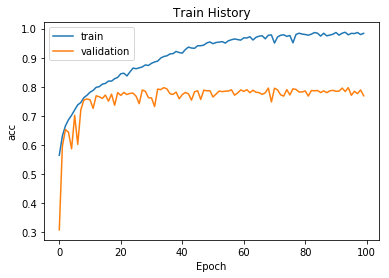

In [9]:
show_plot('acc', train_history)

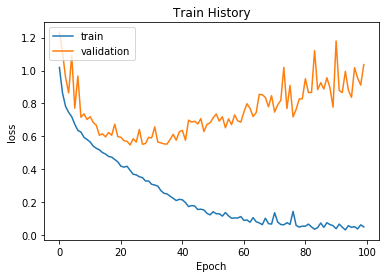

In [10]:
show_plot('loss', train_history)

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation
from keras.utils import np_utils
import tensorflow as tf
from keras.callbacks import EarlyStopping
np.set_printoptions(suppress=True)

data = np.load("/home/hsiehch/30s/2D_spect_img/data_RGB.npy")
labels = np.load('/home/hsiehch/30s/2D_spect_img/labels.npy')

data = data / 255
labels = np_utils.to_categorical(labels, 4)

print(data.shape)
print(labels.shape)

#---------------------------------------

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels)

#---------------------------------------

model = Sequential() 
model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', data_format="channels_last", input_shape = (data.shape[1], data.shape[2], 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = 3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = 3, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(160, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation = "relu"))
model.add(Dense(4, activation = "softmax"))

print(model.summary())

#---------------------------------------

adam = Adam(lr=0.0005)
model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics=['accuracy'])
batch_s = 80
early_stop = EarlyStopping(patience=25)
train_history = model.fit(x = X_train, 
                          y = y_train,
                          epochs=100,
                          validation_split=0.2,
                          callbacks=[early_stop],
                          batch_size=batch_s*1, 
                          verbose=1)


import pylab as plt
def history_display(hist, train, validation):
    plt.plot(hist.history[train])
    plt.plot(hist.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show
    
def show_plot(flag, hist):
    if flag == 'acc':
        history_display(hist, 'acc', 'val_acc')
    elif flag == 'loss':
        history_display(hist, 'loss', 'val_loss')
    else:
        print('Invalid!')

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(10151, 59, 151, 3)
(10151, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 59, 151, 64)       1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 59, 151, 64)       256       
_________________________________________________________________
activation_1 (Activation)    (None, 59, 151, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 151, 64)       36928     
_________________________________________________________________
activation_2 (Activation)    (None, 59, 151, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 75, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 75, 6

6090/6090 [==============================] - 8s 1ms/step - loss: 0.3135 - acc: 0.8775 - val_loss: 0.7368 - val_acc: 0.7492
Epoch 31/100
6090/6090 [==============================] - 8s 1ms/step - loss: 0.3120 - acc: 0.8801 - val_loss: 0.6228 - val_acc: 0.7603
Epoch 32/100
6090/6090 [==============================] - 8s 1ms/step - loss: 0.3127 - acc: 0.8762 - val_loss: 0.6209 - val_acc: 0.7603
Epoch 33/100
6090/6090 [==============================] - 8s 1ms/step - loss: 0.2863 - acc: 0.8854 - val_loss: 0.6345 - val_acc: 0.7754
Epoch 34/100
6090/6090 [==============================] - 8s 1ms/step - loss: 0.2790 - acc: 0.8921 - val_loss: 0.6702 - val_acc: 0.7695
Epoch 35/100
6090/6090 [==============================] - 8s 1ms/step - loss: 0.2902 - acc: 0.8864 - val_loss: 0.6160 - val_acc: 0.7807
Epoch 36/100
6090/6090 [==============================] - 8s 1ms/step - loss: 0.2375 - acc: 0.9085 - val_loss: 0.6331 - val_acc: 0.7669
Epoch 37/100
6090/6090 [==============================] - 8s 

In [3]:
evaluation = model.evaluate(x = X_test, y = y_test)
print('Testing:')
print('Loss: {:.3f}, Accuracy: {:.3f}'.format(evaluation[0], evaluation[1]))

2538/2538 [==============================] - 2s 593us/step
Testing:
Loss: 0.633, Accuracy: 0.804


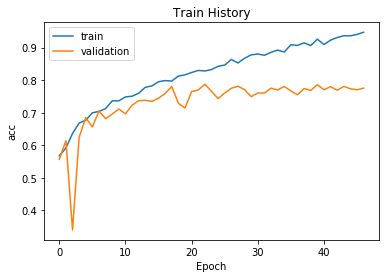

In [4]:
show_plot('acc', train_history)

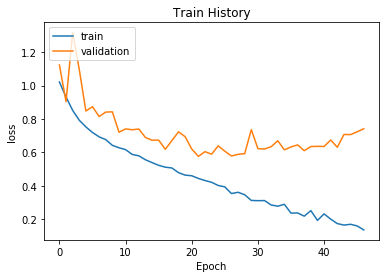

In [5]:
show_plot('loss', train_history)